# **Chap 2：回归类方法**

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist, mnist

## **1 Logistic Regression**

### **1.1 从线性回归扩展到二分类问题**

在之前的学习中，我们已经熟悉了使用**线性回归模型**解决回归类问题的方法，我们再回顾一下线性回归模型问题中的一些知识

模型的输入空间 $\mathcal{X} = \mathbb{R}^p$，输出空间 $\mathcal{Y} = \mathbb{R}$，$T=\{(x_i,y_i)\}_{i=1}^{N}$ 构成训练集，设 $\beta \in\mathbb{R}^p$ 是 $p$ 维向量，考虑预测函数 $f_\beta$：
$$ f_\beta (x) = x\beta $$

模型的假设空间为：
$$\mathcal{F} = \{f_\beta | y=f_{\beta}(x),\beta \in \mathbb{R}^p\}$$

使用均方误差，构造经验损失函数：
$$ R_{emp}(f) = \frac{1}{N}\sum_{i=1}^{N} \left[y_i - f_\beta(x_i)\right]^2 = \frac{1}{N}\|Y - X\beta\|_2^2$$

其中，$X \in \mathbb{R}^{N\times p}$, $Y\in\mathbb{R}^{N\times 1}$ 是由样本组成的特征矩阵和标签向量

模型的策略是极小化上面的经验损失函数，这等价于求上述关于参数 $\beta$ 极小化问题：
$$
f^* = \mathop{\arg\min}\limits_{f\in\mathcal{F}} R_{emp}(f) \quad \leftrightarrow \quad \beta^* = \mathop{\arg\min}\limits_{\beta\in\mathbb{R}^p} \frac{1}{N} \|Y-X\beta\|_2^2
$$

通过求导推到，我们可以得到 $\beta^*$ 的正规方程：
$$ \beta^* = (X^TX)^{-1}X^TY $$

**说明**：在之前，以及接下来的讨论中，为了记号简单，我们都没有提到**截距项**，事实上，**截距项的推广非常简单，这等价于在特征基础上增加了一列 1**

----

现在，假设模型的输出空间 $\mathcal{Y}$ 变为二值离散空间，即 $y_i \in \{0,1\}$，显然沿用之前的预测函数 $f_\beta(x) \in (-\infty,+\infty)$ 不满足要求，我们应该如何处理呢？

核心的关注点是**如何将决策函数的输出映射到 $(0,1)$ 取值**，但改变决策函数之后，整个机器学习模型的后续流程也会随之改变

不变的是，请记住，分析任何机器学习算法，都可以从**模型**，**策略**和**算法**三部分入手，下面对**逻辑回归（Logistic Regression）**的介绍便是如此

#### **1.1.1 模型**

逻辑回归的主要想法是**构造从输入变量** $X$ **到输出变量** $Y$ **的条件概率模型** $P(y|x)$，通过概率 $p(y|x)$ 来完成分类

以二分类为入手点，考虑到输出变量 $y_i \in \{0,1\}$，自然想法是构造二点分布模型，即**二项分布**：
$$
(y|x) \sim b(1,p(x))
$$

具体地，我们可以假设：
$$
P(y=1|x) = p(x)\in (0,1) \quad\text{and}\quad P(y=0|x) = 1 - p(x) \in (0,1)
$$

概率模型的假设有了，如果我们想要**沿用线性模型的框架**，如何将**内积** $x\beta \in \mathbb{R}$ 与 **概率区间** $(0,1)$ **联系在一起呢？**

我们首先关注到**事件的几率 odds**：
$$
odds = \frac{p(x)}{1 - p(x)} = \frac{P(y=1|x)}{P(y=0|x)} \in (0, +\infty)
$$

odds 衡量了两种事件发生大小的比值，它将概率 $p(x) \in (0,1)$ 映射到 $(0,+\infty)$，仅差最后一步，我们将 odds 映射到 $(-\infty,+\infty)$，一个自然的想法是使用对数，于是就有了**对数几率**：
$$
logit = \log{\frac{p(x)}{1 - p(x)}} \in (-\infty, +\infty)
$$

下面，将**线性回归模型**的内积部分接入，我们得到模型：
$$
logit = \log{\frac{p(x)}{1 - p(x)}} = x\beta
$$

经过简单变换，我们能够从上式中解出 $p(x)$ 的具体形式：
$$
p(x) = \frac{1}{1 + \exp{(-x\beta)}},\quad 1 - p(x) = \frac{\exp{(-x\beta)}}{1 + \exp{(-x\beta)}}
$$

这里我们定义函数 $S(x)$：
$$
S(x) = \frac{1}{1 + \exp(-x)},\quad x\in (-\infty,+\infty)
$$

$S(x)$ **被称为Sigmoid函数**，它在机器学习中非常常见，它将实数映射到区间 $(0,1)$ 范围内，并关于 $(0,0.5)$ 对称，非常适合对概率分布建模，其图像如下所示：

<img src="./source/Chap2/sigmoid.png" style="width: 600px" align="left"/>

**Sigmoid函数** $S(x)$ 的另一个重要性质是，可以计算验证，它的**导数能用自身的值来计算**：
$$
S'(x) = S(x)\cdot \left(1 - S(x)\right)
$$

我们可以发现，$p(x)$ 实际上是**Sigmoid函数与线性回归决策函数的复合**

现在，我们在线性模型的框架上，完成了对二值概率 $p(y|x) = p(x)$ 建模，具体到决策函数，可以考虑：
$$
f(x) = \mathbb{I}\{p(x) > \tau\}
$$

其中，$\tau$ 是一个**阈值（threshold）**，用于控制在什么置信程度下，我们将概率 $p(y|x) > \tau$ 的样本判定为正类，即 $y = 1$，默认情况下，我们可以取 $\tau = 0.5$

阈值 $\tau$ 的确定关系到**样本不平衡**问题，以及**ROC 和 AUC**曲线的分析，我们将在下一部分详细讨论

模型的假设空间 $\mathcal{F}$ 即为：
$$
\mathcal{F} = \{f_\beta | y = f_\beta(x) = \mathbb{I}\{p_\beta(x) > \tau\}, \beta\in\mathbb{R}^p,\tau \in (0,1)\}
$$

#### **1.1.2 策略**

与线性回归的框架大体相同，在逻辑回归问题中，决策函数 $f$ 依然与参数 $\beta$ 绑定，构造经验损失函数 $R_{emp}(f)$ 后，模型的策略为：
$$
f^* = \mathop{\arg\min}\limits_{f\in\mathcal{F}} R_{emp}(f) \quad \leftrightarrow \quad \beta^* = \mathop{\arg\min}\limits_{\beta\in\mathbb{R}^p} R_{emp}(f_\beta)
$$

接下来的问题变为，**如何选择经验损失函数中的损失函数** $L\left(y,f(x)\right)$ ?

**(1) 用分类错误率**

一种最朴素的想法是，**关心什么评估指标就把这个指标当作损失函数**

我们现在想要极大化正确率，即最小化分类错误率：
$$
R_{emp}(f) = \frac{1}{N}\sum_{i=1}^{N} \mathbb{I}\{y_i \ne f(x_i)\}
$$

但**当开始考虑优化问题的求解时，立刻就发现上面的想法不可行，这是一个完全无法优化的函数**，因此，有时候**太直接是行不通的**

**(2) 沿用MSE**

另一种想法是**沿用平方损失**，**为了让优化得以进行，我们退一步：不使用决策函数，而是使用概率模型** $p(y|x) = p(x)$ 来参与优化

$$
R_{emp}(f) = \frac{1}{N} \sum_{i=1}^{N} \left[y_i - p(x_i)\right]^2
$$

首先明确，**上述式子是可优化的**，但会有两个问题：
* 直接用实数距离来评估一个概率模型，显得不太“得体”，这从数学理论的解释上不太说得通
* 对经验损失关于 $\beta$ 求导后，会发现结果“丑陋”不美观，不利于优化算法的设计

**(3) 使用似然函数**

**对概率模型损失建模的正确方向是使用似然函数**，逻辑回归模型的似然函数 $L(\beta)$ 为：

$$
L(\beta) = \prod_{i=1}^{N} \left[p_\beta(x_i)\right]^{y_i}\left[1 - p_\beta(x_i)\right]^{1 - y_i}
$$

为了**让模型参数更贴合训练样本**，我们希望**极大化似然函数** $L$，其实本质上，$\beta$ 的求解就是进行**极大似然估计（MLE）**

$$
\beta^* = \mathop{\arg\max}\limits_{\beta \in \mathbb{R}^p} L(\beta)
$$

累乘不便于操作，且为了**与其他机器学习模型极小化经验损失的思想统一**，更一般的方法是考虑**负对数似然函数** $\ell(\beta)$：

$$
\begin{array}{rcl}
\ell(\beta) & = & \displaystyle{-\frac{1}{N} \log L(\beta)} \\
& = & \displaystyle{-\frac{1}{N} \{ \sum_{i=1}^{N} y_i\log\left(p_\beta(x_i)\right) + (1- y_i)\log\left(1 - p_\beta(x_i)\right) \}}\\
& = & \displaystyle{\frac{1}{N} \sum_{i=1}^{N} \left(-y_i x_i\beta + \log{\left(1 + \exp{(x_i\beta)}\right)}\right) }
\end{array}
$$

前面的分式 $1 / N$ 用于消除样本量 $N$ 的影响，本质上不会影响最优解 $\beta^*$，现在，模型的策略为：

$$
\beta^* = \mathop{\arg\min}\limits_{\beta\in\mathbb{R}^p} \ell(\beta) = \mathop{\arg\min}\limits_{\beta\in\mathbb{R}^p} \frac{1}{N} \sum_{i=1}^{N} \left(-y_i x_i\beta + \log{\left(1 + \exp{(x_i\beta)}\right)}\right) 
$$

#### **1.1.3 算法**

很遗憾，**负对数似然函数的优化关于** $\beta$ **没有像线性回归中正规方程那样的解析解**，幸运的是，我们可以使用**梯度下降法**来求解 $\beta^*$

为了便于求导，我们**将负对数似然函数写作Sigmoid函数的表达形式**：
$$
\ell(\beta) = -\frac{1}{N} \sum_{i=1}^{N} { \left[y_i\log{S(x_i\beta)} + (1-y_i)\log{(1 - S(x_i\beta))} \right]}
$$

|记住我们有，$S'(x) = S(x)\left(1 - S(x)\right)$，因此：

$$
\begin{array}{rcl}
\displaystyle{\frac{\partial \ell}{\partial \beta} } & = & \displaystyle{-\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \left(1 - S(x_i\beta)\right) - (1 - y_i)S(x_i\beta)  \right]\cdot x_i  } \\
& = & \displaystyle{-\frac{1}{N} \sum_{i=1}^{N} \left[ y_i - S(x_i\beta)  \right]\cdot x_i  } \\
& = & \displaystyle{ \frac{1}{N} \sum_{i=1}^{N} \left[ p_\beta(x_i) - y_i \right]\cdot x_i \in \mathbb{R}^p } \\
\end{array}
$$

接下来，就可以按照**梯度下降法**的一般流程，编写代码，完成模型的求解

In [2]:
def GradientDescentLogistic(X : np.ndarray, y : np.ndarray, lr : float=0.1, eps : float=1e-8) -> np.ndarray:
    """
    梯度下降法法求解线性回归
    
    Parameters
    ----------
    X : np.ndarray
        输入数据，即特征，维度`(N,p)`
    y : np.ndarray
        真实标签，即预测值，取二值变量`{0,1}`，维度`(N,)`
    lr : float, optional
        梯度下降的学习率，默认值`0.1`
    eps : float, optional
        算法收敛阈值，默认值`1e-8`
    
    Return
    ----------
    beta : np.ndarray
        逻辑回归模型估计得到的最优系数，维度`(p,)`
    """
    # 定义 sigmoid 函数
    def sigmoid(x : np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))
    
    # 特征维度和样本量
    p = X.shape[1]
    N = X.shape[0]
    # 随机初始化 beta，使用正太随机数初始化
    beta = np.random.randn(p)
    # 初始化迭代误差
    err = 1
    
    # 为了防止程序因无法满足阈值条件陷入循环，一般还会设置最大迭代次数保护程序
    max_iter = 100
    # 用 step 存储当前迭代次数
    step = 0
    
    # 开始迭代，当迭代误差小于阈值，或超过最大迭代次数时，程序停止
    while err > eps or step < max_iter:
        # 计算提督
        grad = (1 / N) * (sigmoid(X @ beta) - y) @ X
        # 计算下一步的 beta
        beta_new = beta - lr * grad
        
        # 计算两次迭代之间的误差，使用 L2 范数
        err = np.linalg.norm(beta_new - beta,ord=2)
        # 更新替换 beta
        beta = beta_new
        
        # 更新迭代次数
        step = step + 1
    
    return beta

**相比线性回归的梯度下降算法而言，只有计算梯度的一句代码发生了改变**，可见梯度下降方法的普适性和易用性

----

我们来生成一组数据看看实际的效果

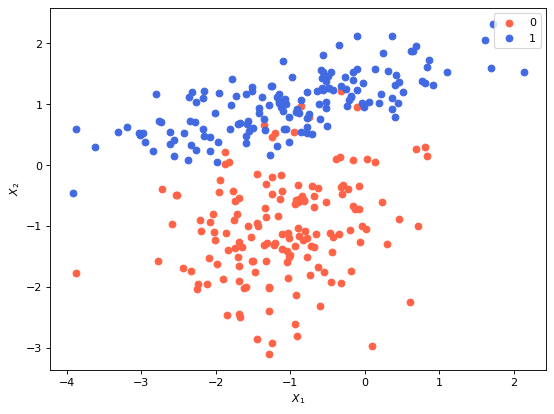

In [3]:
# 生成二分类测试数据，样本量 300, 特征维度 2
# 各个参数的含义可以查看函数文档，需要满足 n_informative + n_redundant + n_repeated <= n_features
X, y = make_classification(n_samples=300, n_features=2, 
                           n_informative=2, n_redundant=0, n_repeated=0, 
                           n_classes=2,n_clusters_per_class=1,
                           random_state=555)

# 绘制样本的分布
fig = plt.figure(figsize=(8,6),dpi=80)
plt.scatter(X[y==0,0], X[y==0,1], c="tomato",label="0") # class 0
plt.scatter(X[y==1,0], X[y==1,1], c="royalblue",label="1") # class 1
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.legend()

下一步，我们将生成的数据随机划分为**训练集**和**测试集**两部分，测试集占比 20%，让模型在训练集上训练，然后评估他在**训练集**和**测试集**上的准确率

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

用我们编写的函数`GradientDescentLogistic()`求解模型系数

In [5]:
# 用梯度下降法求解模型系数
beta = GradientDescentLogistic(X_train,y_train)
# 打印结果
print(beta)

[-0.12587924  3.58504452]


定义一个函数`predictLogistic()`来实验预测，将概率大于 0.5 的样本预测为正类，即 $y=1$

In [6]:
def predictLogistic(X : np.ndarray, beta : np.ndarray) -> np.ndarray:
    """
    predict(X : np.ndarray, beta : np.ndarray) -> np.ndarray
        逻辑回归预测函数
    """
    # 做 sigmoid 变换，计算概率
    p = 1 / (1 + np.exp(- X @ beta))
    # 生成初始预测
    y_hat = np.zeros_like(p)
    # 概率大于 0.5 的预测为 1
    y_hat[p > 0.5] = 1
    
    return y_hat

In [7]:
# 训练集上的预测
y_train_hat = predictLogistic(X_train,beta)
# 在测试集上的预测
y_test_hat = predictLogistic(X_test,beta)

用**准确率**作为评估指标，查看模型在训练集和测试集上的性能

In [8]:
# 用 sklearn 中的准确率函数计算
acc_train = accuracy_score(y_train,y_train_hat)
acc_test = accuracy_score(y_test,y_test_hat)

# 打印结果
print("训练集准确率：%.4f"%(acc_train))
print("测试集准确率：%.4f"%(acc_test))

训练集准确率：0.9250
测试集准确率：0.9667


模型性能表现良好，且没有出现**过拟合**

**逻辑回归方法在第三方软件包`sklearn`中，已经有了很好的实现**，可以通过下面的方法使用

```python
# 导入线性回归模块
from sklearn.linear_model import LogisticRegression

# 初始化模型，设定惩罚系数
model = LogisticRegression(fit_intercept=False)
# 训练模型
model.fit(X_train,y_train)

# 进行预测
y_hat = model.predict(X_test)
```

### **1.2 逻辑回归解决多分类问题**

将上面的逻辑回归模型推广到多分类问题，主要有三种方法：
* 不改变模型，进行一对一分类（**OvO**）
* 不改变模型，进行一对多分类（**OvR**）
* 直接讲模型修改为**多分类**

我们将重点介绍**多分类逻辑回归模型**

我们对模型的假设空间稍作修改，特征空间 $X\in \mathbb{R}^p$ 没有改变，输出空间 $\mathcal{Y}$ 依然是离散空间，但此时有 $K$ 个类别：
$$
y \in \{1,2,\cdots,K\}
$$

#### **1.2.1 一对一 OvO**

**OvO** 的想法是将训练集中的 $K$ 类两两组合，然后对所挑选出的两类样本构建**二分类逻辑回归模型** $f_{p,q}$：

$$
f_{p,q},\quad p<q,\quad p,q\in\{1,2,\cdots,K\}
$$

因此，**OvO方案总共会得到 $C_{K}^2 = K(K-1) / 2$ 个二分类器**

在进行决策预测时，我们用 $C_K^2$ 个分类器做出预测：
$$
\{ \hat{y}_{p,q} \}_{p<q}
$$

然后我们使用**投票机制**，将这组预测中的**众数**作为最终的预测结果：

$$\hat{y} = \text{mode}\left(\{y_{p,q}\} \right)$$

OvO 的建模过程如下图所示：

<img src="./source/Chap2/OvO训练.jpg" style="width: 900px" align="left"/>

<img src="./source/Chap2/OvO预测.png" style="width: 600px" align="left"/>

#### **1.2.2 一对多 OvR**

**OvR** 依然基于**二分类逻辑回归**，对于 $K$ 个类别，**每次拿出其中一个类别** $k$ **作为正类 1**，**其余所有其他类别的样本作为负类 0**，总共得到 $K$ 个分类器：
$$
f_k,\quad k=1,2,\cdots, K
$$

在预测时，我们拿到 $K$ 个模型的预测概率 $p_x(x),k=1,2,\cdots,K$，并**将概率最大所属的类作为最终的预测值**： 
$$
\hat{y} = \mathop{\arg\max}\limits_{k=1,2,\cdots,K} p_k(x)
$$

OvR 的建模过程如下图所示：

<img src="./source/Chap2/OvR训练.png" style="width: 700px" align="left"/>

<img src="./source/Chap2/OvR预测.png" style="width: 600px" align="left"/>

#### **1.2.3 多元逻辑回归建模**

假设训练一个二元逻辑回归的运算复杂度是 $T$，则我们有：
* OvO的训练运算复杂度：$\mathcal{O}(K^2\cdot T)$
* OvR的训练运算复杂度：$\mathcal{O}(K\cdot T)$

在预测性能上，二者的性能差距主要取决于类别数据的分布，在多数情况下二者性能比较接近

一个值得思考的问题是：**OvO 和 OvR 都需要训练多个二分类决策函数组合使用**，比较**繁琐**，有没有方法**只用一个决策函数来对多分类问题建模？**

类似于二元逻辑回归，只不过我们此时需要引入 $K$ 个回归系数 $\beta_k\in\mathbb{R}^p,k=1,2\cdots,K$，然后使用 **Softmax** 变换，来计算样本 $x$ 属于每一类的概率 $p_k(x)$：

$$
p_k(x) = P(Y=k|x) = \frac{\exp(x\beta_k)}{\sum_{j=1}^{K} \exp(x\beta_j)} \in (0,1)
$$

注意：$p_1(x) + p_2(x) + \cdots + p_K(x) = 1$，可以看到，**Softmax** 变换能够将一个 $K$ 维向量 $(x_1,\cdots,x_K)$ 变换为一个概率分布：
$$
\left(\frac{\exp(x_1)}{\sum_{j=1}^{K} \exp(x_j)} ,\cdots, \frac{\exp(x_K)}{\sum_{j=1}^{K} \exp(x_j)}  \right)
$$

**Softmax** 变换时机器学习处理多分类问题，构造概率分布时很常用的一种变换

在预测时，多元逻辑回归模型采用与 **OvR** 相同的思路，即：
$$
\hat{y} = \mathop{\arg\max}\limits_{k=1,2,\cdots,K} p_k(x)
$$

下面，我们具体再说一说多元逻辑回归的建模和求解过程，依然分**模型**，**策略**和**算法**三部分

**(1) 模型**

我们考虑将 $K$ 个系数向量 $\beta_k \in \mathbb{R}^p$ 拼接为一个矩阵 $B$：
$$
B = \left[\beta_1,\cdots,\beta_K\right] \in \mathbb{R}^{p\times K}
$$

对每个样本 $x\in \mathbb{R}^p$，那么概率向量 $\boldsymbol{p}$：
$$
\boldsymbol{p}(x) = \left(p_1(x),\cdots,p_K(x)\right) = \text{Softmax}(xB) \in \mathbb{R}^p
$$

决策函数就是对概率向量 $\boldsymbol{p}$ 的下标 $k$ 取最大值：
$$
f_B(x) = \mathop{\arg\max}\limits_{k=1,2,\cdots,K} \boldsymbol{p}_B(x)
$$

假设空间 $\mathcal{F}$ 为：
$$
\mathcal{F} = \{f_B | y = f_B(x),B\in\mathbb{R}^{p\times K}\}
$$

**(2) 策略**

与二分类逻辑回归类似，我们**从似然函数出发，构造经验损失函数** $R_{emp}(f)$，多分类情况下的似然函数 $L$为：

$$
L = \prod_{i=1}^{N} \left[ \prod_{j=1}^{K} \left( p(y_i = j|x_i) \right)^{\mathbb{I}(y_i = j)} \right]
$$

然后，我们计算**负对数似然函数**，并增加**样本量的缩放因子** $1 / N$，得到 $\ell$：

$$
\ell(B) = -\frac{1}{N}\log{L} = -\frac{1}{N} \sum_{i=1}^{N} \left( \sum_{j=1}^{K} \mathbb{I}(y_i = j)\cdot \log{p\left(y_i = j | x_i\right)} \right) 
$$

我们将 $p(y_i = j|x_i)$ 的表达式代入：
$$
p(y_i = j | x_i) = \frac{ \exp(x_i\beta_j) }{\sum_{k=1}^{K} \exp(x_i\beta_k) } \quad\Rightarrow\quad \log{p(y_i = j | x_i)} = x_i\beta_j - \log{\left( \sum_{k=1}^{K} \exp(x_i\beta_k) \right)}
$$

$$
\ell(B) = -\frac{1}{N} \sum_{i=1}^{N} \left( \sum_{j=1}^{K} x_i\beta_j\mathbb{I}(y_i = j) - \log{\left( \sum_{j=1}^{K} \exp(x_i\beta_j) \right)} \cdot \sum_{j=1}^{K} \mathbb{I}(y_i = j)  \right) 
= \frac{1}{N} \sum_{i=1}^{N} \left(\log{\left( \sum_{j=1}^{K} \exp(x_i\beta_j) \right)} -\sum_{j=1}^{K} x_i\beta_j\mathbb{I}(y_i = j) \right) 
$$

模型的策略是极小化**负对数似然函数**

$$
B^* = \mathop{\arg\min}\limits_{B\in\mathbb{R}^{p\times K}} \ell(B) = \mathop{\arg\min}\limits_{B\in\mathbb{R}^{p\times K}} \frac{1}{N} \sum_{i=1}^{N} \left(\log{\left( \sum_{j=1}^{K} \exp(x_i\beta_j) \right)} -\sum_{j=1}^{K} x_i\beta_j\mathbb{I}(y_i = j) \right) 
$$

**(3) 算法**

求解模型的算法依然使用**梯度下降法**，我们只需要计算 $\ell(B)$ 关于参数 $B$ 的导数

如果觉得一个标量函数对矩阵参数求导很困难，我们可以先让 $\ell$ 对 $\beta_k$ 求导，再将导数拼起来，就得到了 $\ell$ 关于 $B$ 的导数

$$
\frac{\partial \ell}{\partial \beta_k} = \frac{1}{N} \sum_{i=1}^{N}\left( \frac{ \exp(x_i\beta_k) }{ \sum_{j=1}^{K}\exp(x_i\beta_j) } - \mathbb{I}(y_i=k) \right)x_i = 
\frac{\partial \ell}{\partial \beta_k} = \frac{1}{N} \sum_{i=1}^{N}\left( \text{Softmax}(x_iB)_k - \mathbb{I}(y_i=k) \right)x_i \in \mathbb{R}^p
$$

在实际的编程实验中，如果我们设 $\boldsymbol{x} \in \mathbb{R}^{N\times p}$ 表示所有样本特征，系数矩阵 $B\in\mathbb{B}^{p\times K}$，并**将 $K$ 个类别的标签编码为一个 $N\times K$ 的 0-1 矩阵** $\boldsymbol{y}\in \mathbb{R}^{N\times K}$

其中，$\boldsymbol{y}$ **的每一行元素中只有一个为1，其余全部为0**，假设第 $i$ 行的第 $k$ 列元素 $y_{i,k} = 1$，意味着第 $i$ 个样本属于第 $k$ 类，而 $y_{i,j}=0,j\ne k$

则经验损失 $\ell(B)$ 对参数 $B$ 求导的结果为：

$$
\frac{\partial\ell}{\partial B} = \frac{1}{N} \boldsymbol{x}^T \left( \text{Softmax}(\boldsymbol{x}B) - \boldsymbol{y} \right) \in \mathbb{R}^{p\times K}
$$

每次进行导数的计算时，都注意时刻检查矩阵、向量做乘法时结果的维度是否正确

**一些第三方软件包中（例如`sklearn`），提供了将类别标签编码为 0-1 矩阵的功能**：

```python
from sklearn.preprocessing import OneHotEncoder

# 初始化编码器
encoder = OneHotEncoder(dtype=np.float64)
# 将标签 y 编码为 0-1 矩阵
label = encoder.fit_transform(y.reshape(-1,1)).toarray()
```

----

## **2 分类问题的模型评估**

在之前的介绍中，我们实际上隐含了**分类问题中，各个类别样本所占有的比例相当**的假设，接下来我们将看到**类别不平衡**问题，以及我们如何处理它们，以丰富和完善我们对分类问题的评估手段

### **2.1 准确率、召回率和精确率**

在癌症检测分类问题中，由于癌症患病人数极少，例如检测的1000个病患样本中，仅有5个人是患有癌症的，此时就出现了**类别不平衡**问题，设想一下，此时使用**准确率**作为评估指标，会有什么问题？

此时，任何一个模型，**只需要将所有的病患预测为非癌症患者，模型的正确率都有0.995**，如此高的准确率乍一看很唬人，但没有任何实际意义

出现该问题的原因，在于我们**在评估时，没有考虑各类样本所占有的比例**，为此，人们提出了一些更客观的评估指标，例如：**召回率（查全率）**，**精确率（查准率）**和**F1 Score**

我们以二分类问题为例，一个经典的表格为：

<img src="./source/Chap2/查全率和查准率.png" style="width: 600px" align="left"/>

我们先定义一些符号：
* TP(True Positive)：正确标识为正，即算法预测为 1，真实情况也是 1
* FP(False Positive)：错误标识为正，即算法预测为 1，真实情况却是 0
* FN(False Negative)：错误标识为负，即算法预测为 0，真实情况却是 1
* TN(True Negative)：正确标识为负，即算法预测为 0，真实情况也是 0

接下来，我们就能定义**精确率（查准率，Precision）**和**召回率（查全率，Recall）**:

$$
P = \text{查准率} = \frac{TP}{TP + FP},\quad \text{表示预测为 1 的样本中，有多少真正为 1} \\
R = \text{查全率} = \frac{TP}{TP + FN},\quad \text{表示真正为 1 的样本中，有多少预测为 1}\\
$$

需要注意，**查全率和查准率是一对矛盾的变量，一般来说，一个指标高，另一个指标就会低**，因此**在模型评估时，我们会根据业务需要，选择关心哪一个指标**

例如，在前面的**癌症预测**场景中，对于这种高风险疾病的检测，肯定遵循**宁可错杀，绝不放过**的想法，因此我们应该更关注**查全率**，假设此时模型预测的二维表如下：

<img src="./source/Chap2/癌症检测.png" style="width: 600px" align="left"/>

此时，很容易计算得到**模型预测癌症的查准率是 1.0，但查全率只有 0.2**，这显然不是一个好的模型

查准率和查全率是两个矛盾的指标，那有没有办法综合考虑一个模型的预测性能呢？

一种办法是使用**F1 Score**，它综合了 P 和 R，定义如下：
$$
F1 = \frac{2\times P\times R}{P + R} \in [0,1]
$$

F1 Score 的值越大，表明模型对不同类别的区分能力越强，如果模型评估时对 P 或者 R 有一定偏好，例如更看重查全率，可以使用**调整F1 Score**

$$
F_\beta = \frac{(1 + \beta^2)\times P\times R}{(\beta^2 \times P) + R}
$$

另外一种方法，我们可以让模型在不同数据下评估，然后绘制出 **P-R** 曲线，如下图所示：

<img src="./source/Chap2/PR曲线.png" style="width: 600px" align="left"/>

如果一个模型的P-R曲线完全盖住另一个模型，例如途中 B 盖住 C，则可以认为模型 B 的性能在任何方面都超过了 C

如果模型性能在P-R曲线上没有出现完全覆盖的情况，例如途中的 A 和 B，我们可以关注**平衡点BEP（Break-Event Point）**，它是对角线 P=R 与P-R曲线的交点

基于BEP比较，我们可以认为BEP位置越高，模型性能越强，例如途中，模型 A 的性能要优于模型 B

最后需要注意，模型评估需要根据真实场景的需求来确定，不可以盲目选择

此外，**样本不平衡**会对模型训练造成不好的影响，导致模型性能失常，解决样本不平衡的方法也有很多，例如**欠采样**和**过采样**，以及**SMOTE**等，这些不是本课程的重点

### **2.2 混淆矩阵**

**混淆矩阵**能够帮助我们看**清楚模型预测错误的原因来自何处**，或者说，**认清对于模型而来比较难识别的类别是哪些**，从而指导我们对模型进行优化，这在多分类任务场景中尤为有用

事实上，前面关于查全率、查准率的介绍中，TN，FN，FP，TP构成的 $2\times 2$ 表格就是一个二维的混淆矩阵

依然以前面癌症患病预测的表格为例：

<img src="./source/Chap2/癌症检测.png" style="width: 600px" align="left"/>

从上面的混淆矩阵中，我们明确了：
* **模型识别真正患癌症的人的能力不足，容易产生疏漏**，将癌症患者错误标记为健康人，这是模型的核心问题所在
* **模型对健康人群的识别是优秀的**，它不会将健康人错误地判断为癌症患者

下面，我们以**服装识别分类问题**为例子，再来看看如何使用混淆矩阵分析结果，这是一个 10 分类问题

`FashionMnist`数据集提供了 10 中不同的常见服饰的图片数据，每种服饰的图片数据都存储为一个 $28 \times 28$ 的矩阵中

In [47]:
# 导入数据集
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# 打印维度
print(X_train.shape)

(60000, 28, 28)


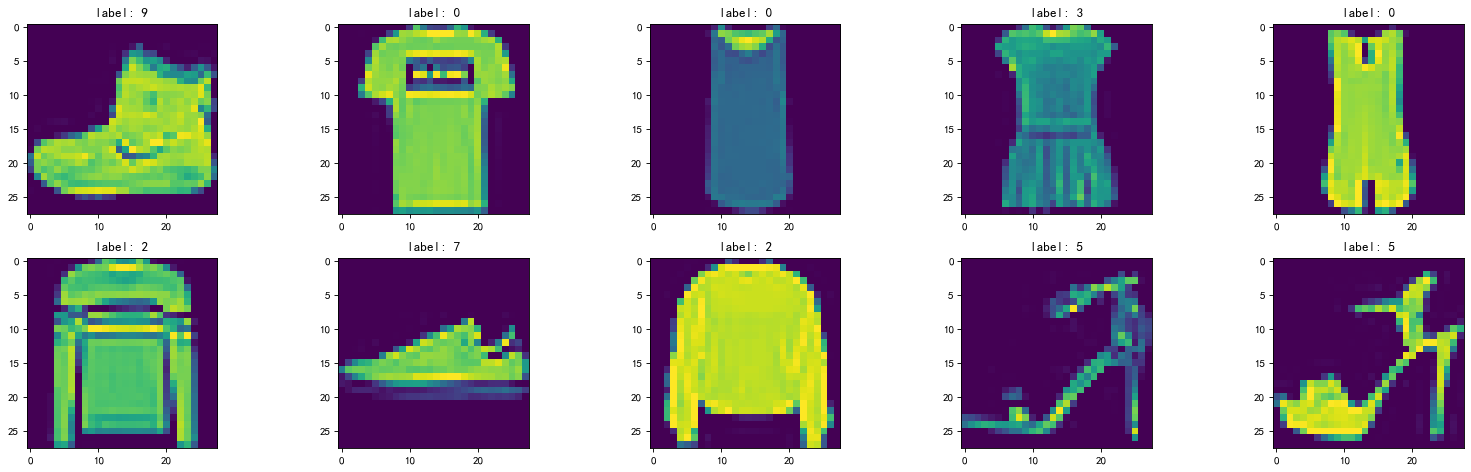

In [50]:
# 绘制 10 个样本
fig, ax = plt.subplots(2,5,figsize=(20,6),dpi=80)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(X_train[i])
    ax[i].set_title("label: %d"%(y_train[i]))
plt.tight_layout()

我们对图片的特征数据做两个预处理，以便于我们的逻辑回归模型能够正确使用：
* 图片的像素值在 $[0, 255]$ 之间，我们通过一个线性变换将其转换为 $(-1,1)$ 之间
* 特征 $X$ 是一个 $28\times 28$ 的矩阵，我们将它**拉直**，成为一个 $28\times 28 = 784$ 维的向量

In [52]:
# 预处理特征
X_train = (X_train - 128) / 128
X_train = np.reshape(X_train, (X_train.shape[0],28*28)) # 第一个维度是样本量 N，特征维度为 28*28 = 784

X_test = (X_test - 128) / 128
X_test = np.reshape(X_test, (X_test.shape[0],28*28))

接下来，构建模型，进行训练，然后做出预测，评估模型在训练集和测试集上的准确率

In [80]:
# 构造模型
model = LogisticRegression(solver="sag")

# 训练
model.fit(X_train, y_train)
# 预测
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

/root/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [81]:
# 性能评估
acc_train = accuracy_score(y_train,y_train_hat)
acc_test = accuracy_score(y_test,y_test_hat)

print("训练集准确率：%.4f"%(acc_train))
print("测试集准确率：%.4f"%(acc_test))

训练集准确率：0.6357
测试集准确率：0.6094


模型好像没有出现**过拟合**，但预测准确率不高，我们来通过**混淆矩阵**分析，模型在哪些类别上预测效果不理想，下面的函数能够帮助我们将**混淆矩阵可视化**

In [75]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plot_confusion_matrix(y_true, y_pred)
        绘制混淆矩阵
        
    Parameters
    ----------
    y_true : np.ndarray
        数据的真实标签
    y_pred : np.ndarray
        模型的预测结果
    labels : list
        各个类别的含义
    """
    import itertools

    acc = accuracy_score(y_true, y_pred)
    mat = confusion_matrix(y_true, y_pred)
    print("accuracy: %.4f"%(acc))
    
    # 绘制混淆矩阵
    fig = plt.figure(figsize=(10,10),dpi=100)
    plt.imshow(mat,cmap=plt.cm.Blues)
    
    thresh = mat.max() / 2
    for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
        # 在每个位置添加上样本量
        plt.text(j, i, mat[i, j],
                 horizontalalignment="center",
                 color="white" if mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xticks(range(mat.shape[0]),labels)
    plt.yticks(range(mat.shape[0]),labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

下表是每个标签对应的服装的含义

| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

accuracy: 0.6082


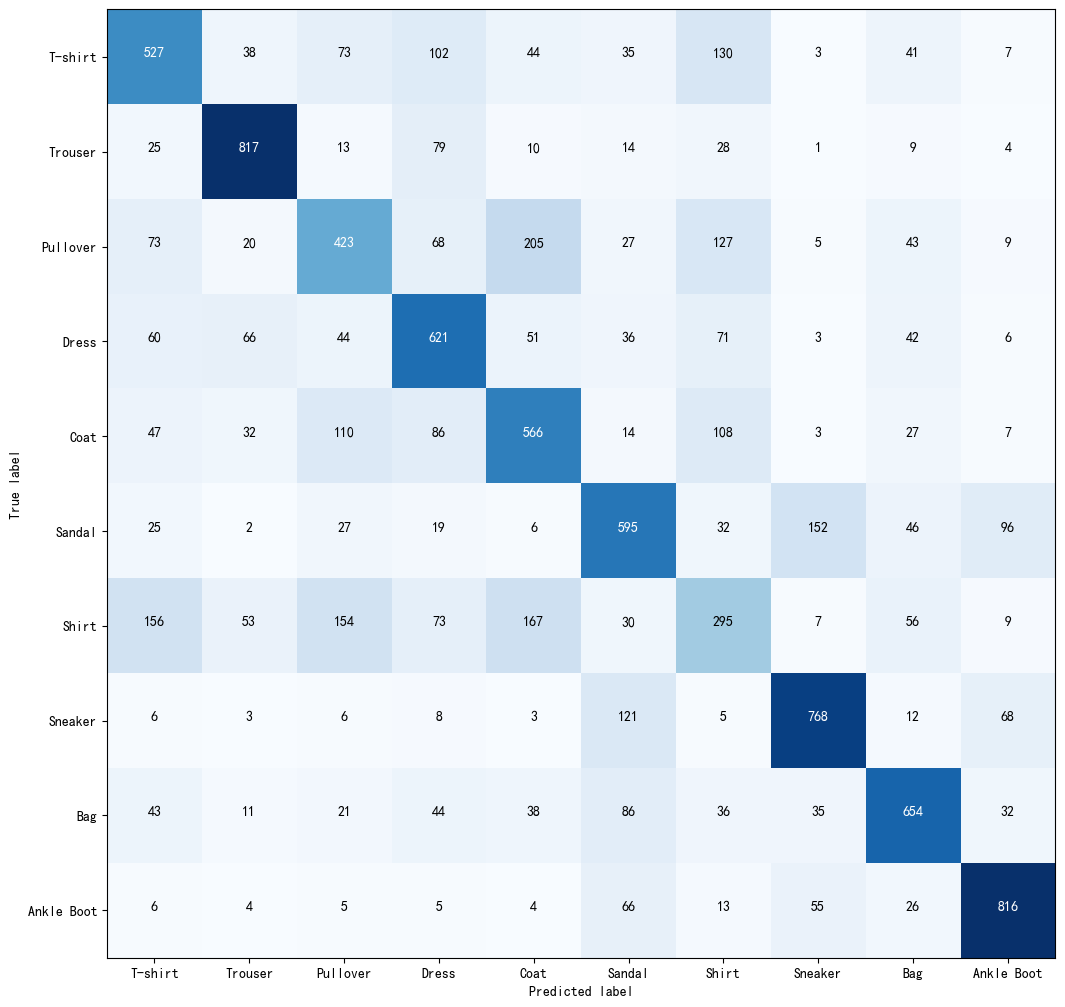

In [76]:
# 进行混淆矩阵分析
labels = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]
plot_confusion_matrix(y_test,y_test_hat,labels)

越集中在对角线的类别，说明模型的预测效果越好，越分散的类别，模型的识别能力越差，从混淆矩阵中，我们能得到：
* 模型对`Trouser`，`Sneaker`，`Ankle Boot`的识别能力优秀
* 模型预测`Pullover`，`Shirt`的能力弱，具体来说：
    * 模型容易将`Pullover`与`Coat`和`Shirt`混淆
    * 模型容易将`Shirt`与`T-shirt`，`Pullover`，`Coat`混淆

因此，模型在外形相似的几个服饰上容易产生混淆，这也是**混淆矩阵**名称的由来

### **2.3 ROC 与 AUC**

在我们介绍二分类逻辑回归时，提到了一个阈值参数 $\tau\in (0,1)$，我们的决策函数 $f$：
$$
f_\beta(x) = \mathbb{I}\{p_\beta(x) < \tau\}
$$

默认情况下，我们选择 $\tau = 0.5$，但如果遇到了**样本不平衡**等问题，$\tau = 0.5$ 可能就不是最优选择，这时候该如何确定 $\tau$ 呢？

**很多分类器都是为测试样本产生一个概率预测** $p$，**然后将这个预测值与一个阈值** $\tau$ **对比**，来决定分为哪一类，此时我们可以借助**真正例率 TPR**和**假正例率 FPR**绘制**ROC曲线**来判断

$$
TPP = \text{真正例率} = \frac{TP}{TP + FP},\quad \text{表示真正为 1 的样本中，有多少预测为 1} \\
FPR = \text{假正例率} = \frac{FP}{FP + TN},\quad \text{表示真正为 0 的样本中，有多少预测为 1}\\
$$

可以发现，**真正例率就是召回率**

**在选择参数** $\tau$ 时，可以**让** $\tau$ **以一定步长遍历区间** $[0,1]$，为每个 $\tau$ 计算TPR和FPR，然后横轴纵轴分别为FPR-TPR，就可以绘制如下的ROC曲线

<img src="./source/Chap2/ROC.jpeg" style="width: 600px" align="left"/>

在进行学习器比较时，与**P-R曲线**类似，有两种方法：
* **如果某个模型 A 的ROC曲线完全盖住另一个模型 B**，则认为 A 完全优于 B
* 如果模型 A 和 B 的ROC曲线有交叉，则可以考虑**AUC（Area Under ROC Curve）**，即**ROC曲线下方的面积**，**AUC越大，分类器性能越好**，具体的：
    * AUC = 1，这是一个完美分类器，对应ROC曲线填满整个正方形，采用这个模型时，不管设定什么阈值 $\tau$，都能得到完美预测，绝大多数情况下不存在完美分类器
    * 0.5 < AUC < 1，优于随机猜测，这个分类器妥善设定阈值能有预测价值
    * AUC = 0.5，模型预测效果和随机猜测一样，没有预测价值
    * AUC < 0.5，模型预测比随机猜测还差，这时候只需要反着预测结果而行，就会优于随机预测

-----

## **3 扩展回归方法：L1惩罚和L2惩罚**

我们在本章的最后一节简单介绍两个扩展的线性回归模型框架：**Ridge** 和 **Lasso**

首先介绍**正则化（Regularization）**的概念，事实上，大部分机器学习模型在构建初期都不会考虑**过拟合问题**，而是尽可能复杂化模型、增加可用的参数以使得模型的学习能力足够强，当发现模型的性能“过剩”，容易在训练集上过拟合时，我们再**在其损失函数中，加入对模型复杂度的惩罚项，以削弱模型的拟合能力**，这个操作就叫做**正则化**

Ridge 和 Lasso 是最经典的两种**正则化方法**，可以用于缓解过拟合，Lasso 还能用于**特征筛选**，两种方法分别对应**L1惩罚**和**L2惩罚**，这两种惩罚是机器学习中最常用的正则化手段，因此在这里引入它们，后续的机器学习模型中我们会时不时看到它们的身影

### **3.1 Ridge**

在上一章的习题部分，我们已经提及到了 Ridge 方法，即**岭回归**，他在线性回归模型的基础上，将回归系数的**2-范数**加入到经验损失中一起优化：

$$
L(\beta) = MSE + \lambda\cdot \|\beta\|_2^2 =  \frac{1}{N}\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2 + \lambda\cdot \sum_{k=1}^{p}\beta_k^2
$$

$\lambda > 0$ 是惩罚系数，用于控制惩罚强度，当 $\lambda = 0$ 时，Ridge 就是普通的线性回归，由于添加的惩罚项时系数的2-范数，因此又被称为**L2惩罚**

针对逻辑回归，L2惩罚依然适用，在负对数似然函数的基础上加上系数的2-范数即可

很容易想象，改变 $\lambda$，模型的性能会在过拟合和欠拟合之间变动：
* 当 $\lambda \to 0$ 时，$\lambda \cdot \|\beta\|_2^2$ 对模型的惩罚小，模型容易在训练集上过拟合
* 当 $\lambda \to \infty$时，为了最小化损失函数，极端一些，所有系数都设置为 0，$\lambda \cdot \|\beta\|_2^2$ 就不会再惩罚模型，损失仅来自前一部分的数据拟合误差，而这一部分误差与 $\lambda$ 无关是有上限的，此时模型严重欠拟合（因为完全失去了拟合能力）

下图展示了，一个 $\beta \in \mathbb{R}^8$ 的模型的系数是如何随着 $\lambda$ 的增大，**逐步被惩罚到 0 的**

<img src="./source/Chap2/ridge.png" style="width: 600px" align="left"/>

此外，**L2惩罚是一种“光滑”惩罚，或软惩罚**，这里所说的光滑性体现在：
* 加入L2惩罚的经验损失函数依然能够对参数 $\beta$ 求导
* 从上图观察到，随着 $\lambda$ 增大，系数 $\beta$ 的**各个分量是同时渐渐顺滑的衰减**到 0 的，**这和 Lasso 有很大不同**

**Ridge方法同样在`sklearn`中有成熟的实现**，使用方法如下：

```python
from sklearn.linear_model import Ridge

# 建立模型
model = Ridge(alpha=1) # 设置惩罚系数
# 训练模型
model.fit(X_train,y_train)
# 进行预测
y_hat = model.predict(X_test)
```

如果你**想在逻辑回归任务中使用 Ridge 方法**，指定**惩罚项（penalty）**为`l2`即可

```python
from sklearn.linear_model import LogisticRegression

# 建立模型
model = LogisticRegression(penalty='l2',C=1.0) # 指定使用 L2 惩罚，设置惩罚系数 C，这里 C = 1 / lambda
# 训练模型
model.fit(X_train,y_train)
# 进行预测
y_hat = model.predict(X_test)
```

### **3.2 Lasso**

Lasso 同样在经验损失中加入对系数的惩罚，不过这次加入的是系数的**1-范数**:

$$
L(\beta) = MSE + \lambda\cdot \|\beta\|_1= \frac{1}{N}\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2 + \lambda\cdot \sum_{k=1}^{p}|\beta_k|
$$

$\lambda > 0$ 是惩罚系数，用于控制惩罚强度，当 $\lambda = 0$ 时，Ridge 就是普通的线性回归，由于添加的惩罚项时系数的1-范数，因此又被称为**L1惩罚**

针对逻辑回归，L1惩罚依然适用，在负对数似然函数的基础上加上系数的1-范数即可

**Lasso 惩罚与 Ridge 的相同点**在于，当 $\lambda \to 0$ 时，惩罚力度小，模型接近一般的线性回归，容易在训练集上**过拟合**；当 $\lambda \to\infty$ 时，惩罚力度大，**模型复杂度降低，直至所有系数被惩罚到 0**

但 Lasso 与 Ridge 在系数惩罚的衰减特性上，有很大的不同，Lasso 进行的是**稀疏惩罚**。对于同一个 $\beta\in\mathbb{R}^8$ 的问题，Lasso 估计的系数随着 $\lambda$ 变化的规律如下图：

<img src="./source/Chap2/lasso.png" style="width: 600px" align="left"/>

从图中，我们可以观察到，**随着 $\lambda$ 增大，系数 $\beta$ 的每个分量，被一个一个惩罚到 0**，这就是我们所说的**稀疏性惩罚**，而 **RIdge 没有这个特性**，它仅在 $\lambda \to \infty$ 时，所有系数同时衰减到 0

**L1惩罚作为"稀疏"惩罚，或硬惩罚**，有以下性质：
* 系数被逐个惩罚到 0，因此当为模型选定某个 $\lambda$ 时，只有部分系数不为 0，这就是所谓的**稀疏性**
* 从惩罚路径图可以看到，$\beta$ 各个分量的变化是**分段线性的**，而 Ridge 惩罚的路径是光滑的
* **L1惩罚在加入损失函数后，损失函数对参数无法求导**，此时想要求解优化模型，可以考虑**次梯度**以及**坐标下降法**等更复杂的优化方法
* **稀疏性产生的本质原因，是因为L1范数作为系数的函数，是奇异的**，这里的**奇异性指存在不可导的点**，Lasso 不是唯一会产生稀疏解的模型（例如**SCAD**）

**Lasso方法同样在`sklearn`中有成熟的实现**，使用方法如下：

```python
from sklearn.linear_model import Lasso

# 建立模型
model = Lasso(alpha=1) # 设置惩罚系数
# 训练模型
model.fit(X_train,y_train)
# 进行预测
y_hat = model.predict(X_test)
```

如果你**想在逻辑回归任务中使用 Lasso 方法**，指定**惩罚项（penalty）**为`l1`，并**挑选一个支持L1惩罚的优化器**

```python
from sklearn.linear_model import LogisticRegression

# 建立模型
# 记得指定优化器，这里可以使用 'liblinear' 或者 'saga'
model = LogisticRegression(penalty='l1',C=1.0,solver='liblinear') # 指定使用 L2 惩罚，设置惩罚系数 C，这里 C = 1 / lambda
# 训练模型
model.fit(X_train,y_train)
# 进行预测
y_hat = model.predict(X_test)
```

### **3.3 Ridge 和 Lasso 对比**

我们还能再进一步讨论**L1惩罚**和**L2惩罚**的区别，以及我们该如何做选择

在优化相关的课程中，可以证明以下两个优化问题等价：

$$
\min {\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2 + \lambda\cdot \sum_{j=1}^{p} |\beta_j|^q} \quad\Leftrightarrow\quad \exists C>0,\quad \min {\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2} \quad\text{s.t.}\quad \sum_{j=1}^{p} |\beta_j|^q\leq C
$$

那么**L1惩罚**和**L2惩罚**对应的优化问题可以写作：

$$
\text{L1: }\quad \min {\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2} \quad\text{s.t.}\quad \sum_{j=1}^{p} |\beta_j|\leq C \\
\text{L2: }\quad \min {\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2} \quad\text{s.t.}\quad \sum_{j=1}^{p} \beta_j^2\leq C \\
$$

这时候，一个**最经典的图来**描述**L1惩罚**和**L2惩罚**的区别如下图：

<img src="./source/Chap2/L1L2对比.png" style="width: 800px" align="left"/>

左边的场景代表L1惩罚，右边的图代表L2惩罚，如何解读上面的图呢？
* 两张图右上部分的同心椭圆环代表等价问题中的优化目标等值线图，在这里就是均方误差：
$$ \sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2 $$
* $\hat{\beta}$ 代表优化目标的极值点，即我们的目标所求，如果是均方误差，则 $\hat{\beta} = (X^TX)^{-1}X^Ty$
* 蓝色区域代表了优化问题中的约束，**L1的绝对值函数对应正方形，L2的平方函数对应圆形**
$$ \text{L1: }\quad\sum_{j=1}^{p} |\beta_j| \leq C\quad\quad  \text{L2: }\quad\sum_{j=1}^{p} \beta_j^2 \leq C$$
* 上面提到的等价优化问题，需要在蓝色区域内，找到距离 $\hat{\beta}$ 最近的点
* 对 **L2 惩罚**，**优化目标等值线与圆周上任何一点接触的概率相等**，此时**产生稀疏解（即落到圆周与坐标轴交点）的概率为0**
* 对 **L1 惩罚**，**优化目标等值线大概率会与正方形与坐标轴的交点接触**(或者反过来，可以说明**等值线与正方形四边先接触的概率零测**)，此时就产生了**稀疏解**

还有另一种解释**L1惩罚**和**L2惩罚**区别的方法，是从参数 $\beta$ 的先验分布出发：
* **L2惩罚** 假设 $\beta$ 的先验分布是 **Gauss 分布**
* **L1惩罚** 假设 $\beta$ 的先验分布是 **Laplace 分布**，从而产生了稀疏解

更多相关的讨论，可以查阅相关的文献和资料，我们**在实践中更关心的问题是，该如何选择使用哪一种惩罚方法呢？**

该问题没有标准答案，需要根据实际问题分析，但总体可以总结为下面两条：
* 如果**希望所有特征都参与建模预测**，让每个特征都发挥作用，或者有**先验知识知道每个特征都是有效的（informative）**，又或者**特征维度** $p$ **不太大**，样本量 $N$ 充足时，可以优先考虑**L2惩罚**
* 如果**特征维度** $p$ **较大**，且**缺乏对哪些特征是有效的先验知识时**，优先考虑**L1惩罚**，L1惩罚得到的稀疏系数，还能帮助我们做**特征筛选**

当然，还有另外一种选择，全都要！我们可以**在损失函数中同时加入L1惩罚和L2惩罚**，这就得到了**弹性网络（ElasticNet）**

$$
L(\beta) = MSE + \lambda_1\cdot \|\beta\|_1 + \lambda_2\cdot \|\beta\|_2^2 = \frac{1}{N}\sum_{i=1}^{N} \left[y_i - x_i\beta\right]^2 + \lambda_1\cdot \sum_{k=1}^{p}|\beta_k|\cdot \lambda_2\cdot \sum_{k=1}^{p} \beta_k^2
$$

**`sklearn`中已经有了很好的实现，直接使用即可**

```python
from sklean.linear_model import ElasticNet
```

---

## **练习**

1. 我们利用`make_classification()`函数来生成一组分类数据，在完成多分类任务的同时，理解L1和L2惩罚的区别

(1) 用`make_classification()`生成一组样本 $X,y$，参数设置如下：
* 样本量：n_samples = 200
* 特征数量：n_features = 6
* 有效特征数量：n_informative = 2
* 冗余特征数量：n_redundant = 0
* 重复特征数量：n_repeated = 0
* 类别数量：n_classes = 4
* 每个类别的聚集数量：n_clusters_per_class = 1
* 类别之间间隔：class_sep = 1.5
* 随机数种子：random_state = 4321

(2) 用`train_test_split()`函数将样本随机切分为训练集`(X_train,y_train)`和测试集`(X_test,y_test)`，测试集比例为40%

(3) 由于特征维度 $p=6$ 大于 $2$，因此我们无法直接可视化数据，下面的函数`plot_classes()`能通过投影的方式，将数据可视化到两两坐标轴上，将`(X_train,y_train)`作为参数传入进行可视化

根据可视化的结果，你能判断**哪两个特征是数据生成时的有效特征(imformative)吗？**

In [63]:
def plot_classes(X : np.ndarray, y : np.ndarray):
    """
    利用投影，将分类数据集可视化到两两坐标轴上
    
    Parameters
    ----------
    X : np.ndarray
        输入数据，即特征，维度`(N,p)`
    y : np.ndarray
        真实标签，即预测值，离散变量`{0,1,...,K}`，维度`(N,)`
    """
    fig, ax = plt.subplots(3,5,figsize=(20,12),dpi=80)
    ax = ax.flatten()
    loc = 0
    colors = ["royalblue","tomato","limegreen","magenta"]
    for i in range(6):
        for j in range(i+1,6):
            for k in range(4):
                ax[loc].scatter(X[y == k,i],X[y == k,j],c=colors[k],label=k)
                ax[loc].set_xlabel("$X_%s$"%(i+1),fontsize=14)
                ax[loc].set_ylabel("$X_%s$"%(j+1),fontsize=14)
            loc += 1
    plt.tight_layout()

(4) 使用`sklearn`中的`LogisticRegression()`方法，分别设置`penalty`参数对模型进行L1和L2惩罚，惩罚系数 $C$ 以 $0.02$ 为间隔，从 $2$ 减小到 $0.02$，绘制6个特征对应的回归系数 $\beta_1,\cdots,\beta_6$ 随着 $C$ 的变化趋势

* 观察L1惩罚和L2惩罚的异同
* 哪个惩罚更适合做特征筛选？
* 根据系数变化曲线，筛选得到的两个特征和在**滴3问**中你的观察结果一致吗？
* 比较L1惩罚和L2惩罚在测试集上的准确率

(5) 如果你感兴趣，可以尝试在生成数据时，保持其他参数不变，特征数量`n_features`改为50，此时再使用L1和L2惩罚，对比它们在测试集上的准确率，你会得到什么结论？

2. 我们来使用逻辑回归算法实现**数字识别**

(1) 利用`keras`中的模块，导入**手写数字识别数据集**，代码如下

In [ ]:
# 导入手写数字识别数据集
(X_train, y_train), (X_test, y_test) = mnist.load_data()

下面的代码能帮助你绘制前十个样本

In [ ]:
# 绘制前10个样本
fig, ax = plt.subplots(2,5,figsize=(10,4),dpi=80)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(X_train[i],cmap=plt.cm.Greys)
    ax[i].set_title("Label: %d"%(y_train[i]))
plt.tight_layout()

(2) 为了输入符合要求，我们需要对输入的图像做变换：
* 由于图片的像素值处于 $[0,255]$ 之间，请将值变换到区间 $[0,1]$ 范围之内
* 图片输入是一个二维矩阵，逻辑回归不支持直接以矩阵特征，可使用`np.reshape()`方法，将矩阵“拉直”为向量

(3) 训练逻辑回归模型，汇报它在训练集上和测试集上的准确率，模型有出现过拟合吗？

(4) 绘制模型在测试集上的混淆矩阵，模型最容易把哪个数字识别错？

----